# Image dataset
This segmentation algorithm was tested on the PMID2019 dataset: a collection of bright field microscopy images.

In [1]:
#loading of the packages
import numpy as np
from scipy import ndimage
import skimage.io
from skimage import morphology
from skimage import filters
from skimage import transform
from skimage import draw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import pandas as pd
import sys
import time
import pickle
import importlib
#custom packages
function_dir = os.path.join(os.pardir, 'Functions')
sys.path.append(function_dir)

import segmentation as seg
importlib.reload(seg) #to make sure the last version of seg is used


<module 'segmentation' from '..\\Functions\\segmentation.py'>

In [2]:
#loading of the images

data_base_path = os.path.join(os.pardir, 'Datasets')
#data_folder = os.path.join('Aquascope','raw_only')
data_folder = os.path.join('PMID2019','JPEGImages')
data_path = os.path.join(data_base_path, data_folder)


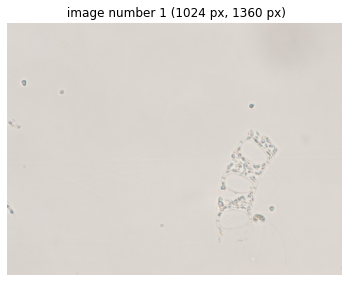

In [4]:
#test the validity of one random img
i = 1#change value to change img
img = skimage.io.imread(os.path.join(data_path, os.listdir(data_path)[i]))
im_h, im_w, im_channel = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title(' image number '+str(i)+' ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


As most images contain mainly white parts, the first step is to select ROI. Here is the principle described for one image:

In [5]:
threshold = 0.1
min_area  = 2000 #minimal area to filter out noise (in pixels)

the preprocessing took: 
 - 0.005006700000002695s to shrink the image
 - 0.010863799999999202s to process the high pass filter
 - 0.0019434999999994318s to normalize the image
 - 0.00024859999999904403s to binarize it
 - 0.03080280000000002s to close it
 - 0.001825199999998972s to label it
 - 0.004594600000000781s to filter it 
 ----TOTAL: 0.055285200000000145


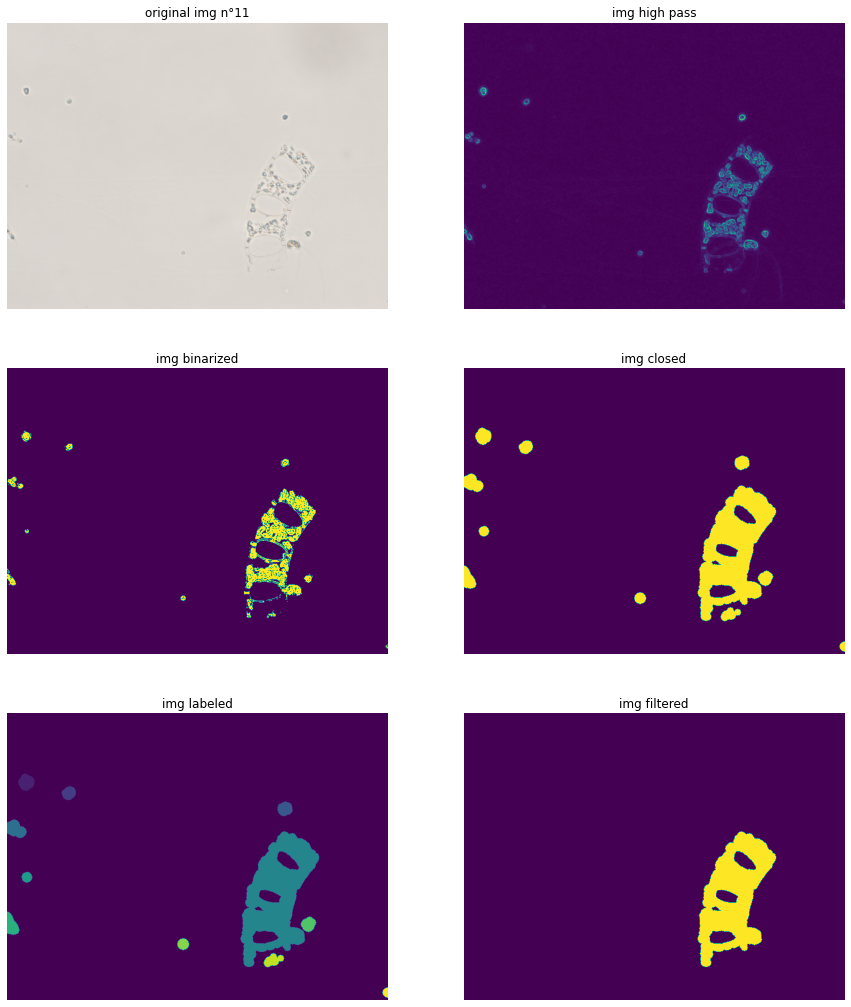

In [6]:
t0 = time.perf_counter()
#shrink the image to fasten the calculations, and turn it grey
img_small = np.sum(img[0::2,0::2],axis = 2)
t00 = time.perf_counter()
#sobel:
img_border = filters.sobel(img_small)
t1 = time.perf_counter()

#normalize the sobel filtered images
b_min = np.min(img_border)
b_max = np.max(img_border)
diff = b_max-b_min
img_bordern = (img_border-b_min)/diff
t2 = time.perf_counter()

#binarize
img_bin = img_bordern > threshold
t3 = time.perf_counter()

#morphological closing
img_close = morphology.binary_dilation(img_bin,selem = morphology.disk(6))
t4 = time.perf_counter()

#watershed
img_label, n_ROI = ndimage.label(img_close.astype(int))
t5 = time.perf_counter()

#filter out the parts too small to be an image as well as the background
ids, count = np.unique(img_label,return_counts = True)
new_ids = np.zeros((ids[-1]+1), dtype = int)
j = 0
for i,c in zip(ids,count):
    if c != np.max(count) and c > min_area:
            j = j+1
            new_ids[i]=j

#apply the filter:
if ids[-1]>1:
    img_filtered = new_ids[img_label[:,:]]
else:
    img_filtered = np.zeros(np.shape(img_label),dtype = int)
t6 = time.perf_counter()            


#print performances:
print('the preprocessing took: \n - '
     +str(t00-t0)+'s to shrink the image\n - '
     +str(t1-t00)+'s to process the high pass filter\n - '
     +str(t2-t1)+'s to normalize the image\n - '
     +str(t3-t2)+'s to binarize it\n - '
     +str(t4-t3)+'s to close it\n - '
     +str(t5-t4)+'s to label it\n - '
     +str(t6-t5)+'s to filter it \n ----TOTAL: '+str(t6-t0))

#plot
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

ax[0,0].imshow(img)
ax[0,0].set_title('original img n°'+str(i))
ax[0,0].axis('off')

ax[0,1].set_title('img high pass')
ax[0,1].imshow(img_bordern)
ax[0,1].axis('off')

ax[1,0].set_title('img binarized')
ax[1,0].imshow(img_bin)
ax[1,0].axis('off')

ax[1,1].set_title('img closed')
ax[1,1].imshow(img_close)
ax[1,1].axis('off')

ax[2,0].set_title('img labeled')
ax[2,0].imshow(img_label)
ax[2,0].axis('off')

ax[2,1].set_title('img filtered')
ax[2,1].imshow(img_filtered)
ax[2,1].axis('off')
plt.show()


Once the images are correctly labeled, one can segment the wanted ROI and store them in a list

In [8]:
margin = 5
ROI_list = []
for i in range(1,j+1):
    x,y = np.where(img_filtered ==i)
    xmin = 2*max(np.min(x)-margin,0)
    ymin = 2*max(np.min(y)-margin,0)
    xmax = 2*min(np.max(x)+margin,im_h//2)
    ymax = 2*min(np.max(y)+margin,im_w//2)
    ROI_list.append(img[xmin:xmax,ymin:ymax])

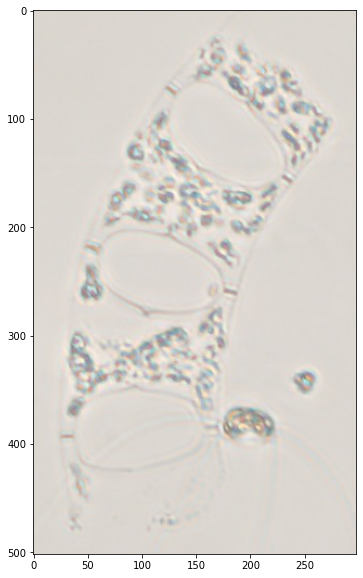

In [9]:
fig, ax = plt.subplots(len(ROI_list), figsize=(15, 10))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
else:
    ax.imshow(ROI_list[0])

The previously seen function have been integrated in segmentation.py file, allowing an easy reuse of them

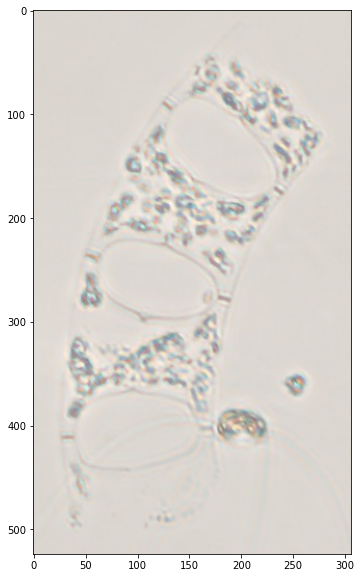

In [10]:
#i = 456 #change value to change img
#img = skimage.io.imread(os.path.join(data_path, 'SPC-EAWAG-5P0X-1635411681512843-39918823952846-000019-002-1766-1510-52-52_rawcolor.jpeg'))
img_label = seg.label_img(img,dil_size = 4)
ROI_list = seg.segment(img, img_label)
fig, ax = plt.subplots(len(ROI_list), figsize=(15, 10))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
else:
    ax.imshow(ROI_list[0])

The preprocessing steps are used on all images:

In [55]:
ROI_list = []
n_max = 10000
for i,folder in enumerate(os.listdir(data_path)):
    if i%10 == 0:
        print(str(i)+'/'+str(len(os.listdir(data_path))),end='\r')
    img = skimage.io.imread(os.path.join(data_path, folder))
    img_label = seg.label_img(img, plot = False, th = 0.05, min_area = 100,shrink_factor = 3,dil_size = 4)
    #ROI_list+=seg.segment(img, img_label)
    ROI_list.append(img)

In [56]:
len(ROI_list)

251

In [ ]:
fig, ax = plt.subplots(len(ROI_list), figsize=(18, 100))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
else:
    ax.imshow(ROI_list[0])

The list of ROI is saved in order not to recompute the segmentation too often

In [23]:
pickle_folder = os.path.join('PMID2019', 'pickle_ROI')
pickle_path = os.path.join(data_base_path, pickle_folder)

In [13]:
save_file = 'ROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(ROI_list, f)

In [24]:
with open(os.path.join(pickle_path,'ROI_list2.pickle'),'rb') as f:
    ROI_list = pickle.load(f)

In [12]:
len(ROI_list)

12392

In [29]:
BigROI_list = []
for ROI in ROI_list:
    if np.min(ROI.shape[0:-1])>512:
        BigROI_list.append(ROI)

In [30]:
len(BigROI_list)

2201

In [31]:
np.min(ROI.shape[0:2])

392

In [32]:
ROI.shape

(450, 392, 3)

In [35]:

for el in BigROI_list:
    if(np.min(el.shape[:-1])<256):
        print(el.shape)

In [36]:
save_file = 'BigROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(BigROI_list, f)

This list of ROI could already be used to train some neural networks, but to speed up the process, one could think of already cropping the list to some (256,256) slices with interesting features. This should speed up the learning process by removing part of the randomness of the training data and only train on usefull images 

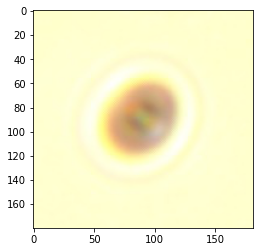

In [21]:
img = ROI_list[1]
plt.imshow(img)

In [28]:
#first create a list of all crops of an image. To have a minimum amount of bias, the cropping algorithm starts
#once from the top left and once from the bottom right (and revert these, augmenting implicitely the data)
def crop(img,size=256,stride=128):
    w,h,c = img.shape
    n_hori = int((w-size)/stride)
    n_vert = int((h-size)/stride)
    if n_hori > 0 and n_vert > 0:
        n_half = n_hori*n_vert
        crops = np.zeros((size,size,c,2*n_half),dtype = np.uint8)
        for i in range(n_hori):
            for j in range(n_vert):
                crops[:,:,:,i+n_hori*j] =      img[i*stride:i*stride+size,
                                                   j*stride:j*stride+size,:]
                crops[:,:,:,n_half+i+n_hori*j]=img[w-i*stride-1:w-(i*stride+size)-1:-1,
                                                   h-j*stride-1:h-(j*stride+size)-1:-1,:]
        return crops
    else:
        return np.zeros((size,size,c,0),dtype=np.uint8)

In [29]:
crop(img)

array([], shape=(256, 256, 3, 0), dtype=uint8)

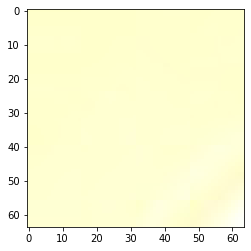

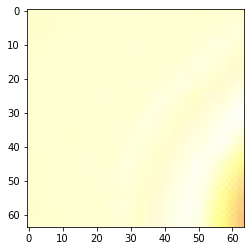

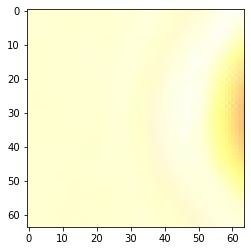

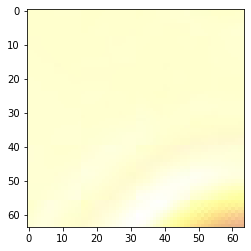

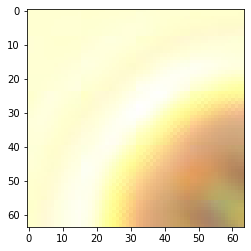

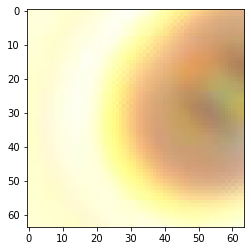

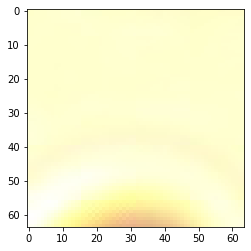

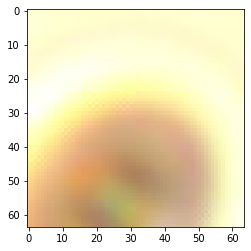

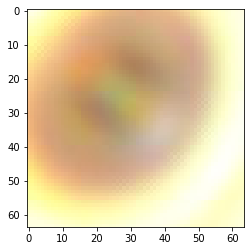

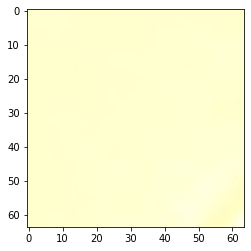

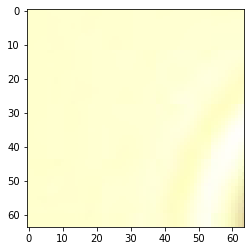

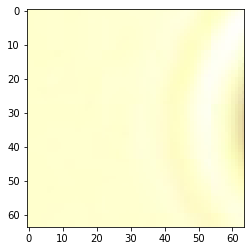

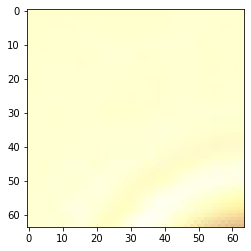

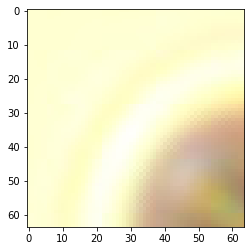

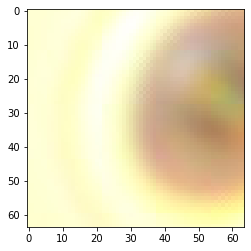

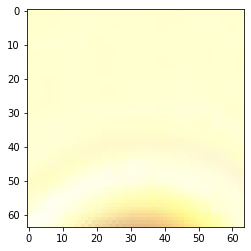

In [30]:
for i in range(16):
    plt.imshow(crop(img,size =64,stride=32)[:,:,:,i])
    plt.show()

In [31]:
def filter_crops(crops,min_diff=100,perclow=1,perchigh=99):
    f_crops = []
    for idx in range(crops.shape[-1]):
        crop = crops[:,:,:,idx]
        pl = np.percentile(crop,perclow)
        ph = np.percentile(crop,perchigh)
        if ph-pl > min_diff:
            f_crops.append(crop)
    return f_crops

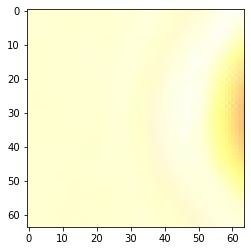

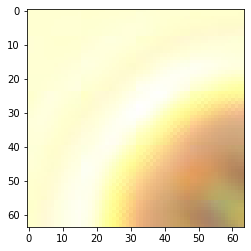

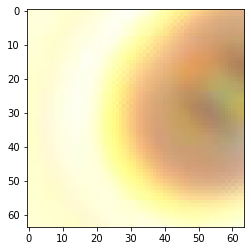

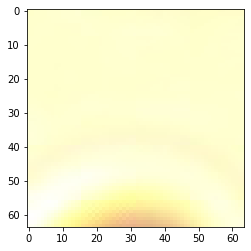

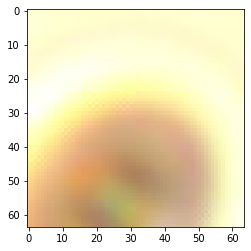

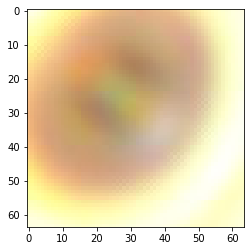

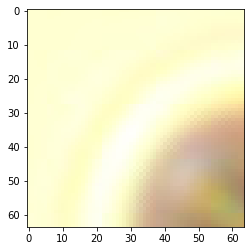

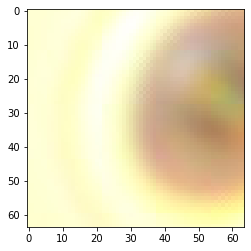

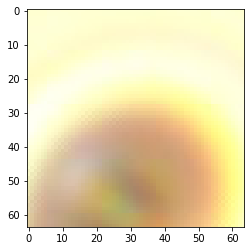

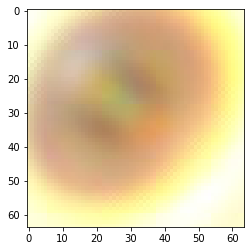

In [33]:
filtered_c = filter_crops(crop(img,size = 64,stride=32),min_diff = 100)
for i in range(len(filtered_c)):
    plt.imshow(filtered_c[i])
    plt.show()

In [34]:
#build a list with all crops from all images
size = 64
stride = 32
colors = 3

crops_usefull = []
for i,img in enumerate(ROI_list):
    if i%10==0:
        print("processing ROI "+str(i)+"/"+str(len(ROI_list)),end = '\r')
    crops = crop(img,size = size, stride = stride)
    if crops.shape[-1]==0:
        continue
    f_crops = filter_crops(crops)
    crops_usefull+=f_crops
print("processing over                              ")

KeyboardInterrupt: 

In [35]:
print(len(crops_usefull))

463085


In [ ]:
ROI_list = []

In [37]:
#save and export these usefull crops
save_file = 'crops_64_1.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(crops_usefull[0:10000], f)

In [17]:
crops_usefull = []